# Расширенный регрессионный анализ: Auto-MPG dataset

1. Ridge-регрессия (с подбором alpha через CV, графики cv.plot / bias.plot, VIF, значимость, сравнение с OLS)
2. Квантильная регрессия для разных tau (визуализация коэффициентов, сравнение OLS vs медианной регрессии)
3. Полиномиальная регрессия (квадратичная и кубическая) + сравнение с линейной моделью

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.quantile_regression import QuantReg

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

plt.rcParams['figure.figsize'] = (9, 6)

## Загрузка и подготовка данных Auto-MPG

In [34]:
columnNames = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
autoMpgDataFrame = pd.read_csv('datasets/auto-mpg.data', delim_whitespace=True, names=columnNames, na_values='?')
autoMpgDataFrame = autoMpgDataFrame.dropna().reset_index(drop=True)

# Добавляем dummy-переменные для origin (baseline = 1, USA)
autoMpgDataFrame['originEurope'] = (autoMpgDataFrame['origin'] == 2).astype(int)
autoMpgDataFrame['originJapan'] = (autoMpgDataFrame['origin'] == 3).astype(int)

print('Размер очищенной выборки:', len(autoMpgDataFrame))
display(autoMpgDataFrame.head())

Размер очищенной выборки: 392


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,originEurope,originJapan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,0,0


## 1. Ridge-регрессия для mpg

In [35]:
features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'originEurope', 'originJapan']

yMpg = autoMpgDataFrame['mpg']
xMpg = autoMpgDataFrame[features]

### Стандартизация для Ridge

In [36]:
scalerMpg = StandardScaler()
xMpgScaled = scalerMpg.fit_transform(xMpg)
xMpgScaledDf = pd.DataFrame(xMpgScaled, columns=features)

### Подбор alpha через RidgeCV

In [37]:
alphaGrid = np.logspace(-4, 4, 1000)
ridgeCv = RidgeCV(alphas=alphaGrid, scoring='neg_mean_squared_error', store_cv_results=True)
ridgeCv.fit(xMpgScaled, yMpg)
bestAlpha = ridgeCv.alpha_
print(f'Лучшее alpha (по CV) = {bestAlpha:.6g}')

Лучшее alpha (по CV) = 1.54237


### CV plot

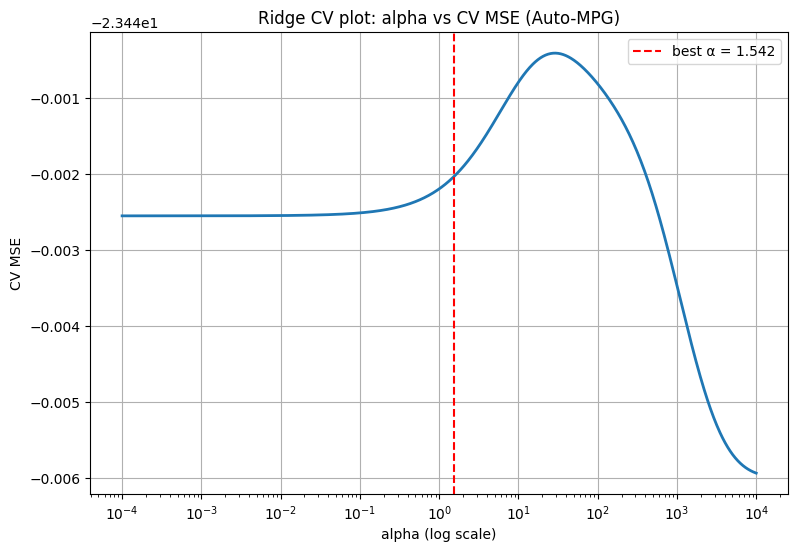

In [38]:
meanCvMse = -np.mean(ridgeCv.cv_results_, axis=0)
plt.figure()
plt.semilogx(alphaGrid, meanCvMse, lw=2)
plt.axvline(bestAlpha, color='red', linestyle='--', label=f'best α = {bestAlpha:.4g}')
plt.xlabel('alpha (log scale)')
plt.ylabel('CV MSE')
plt.title('Ridge CV plot: alpha vs CV MSE (Auto-MPG)')
plt.legend()
plt.grid(True)
plt.show()

### Bias plot (коэффициенты vs alpha)

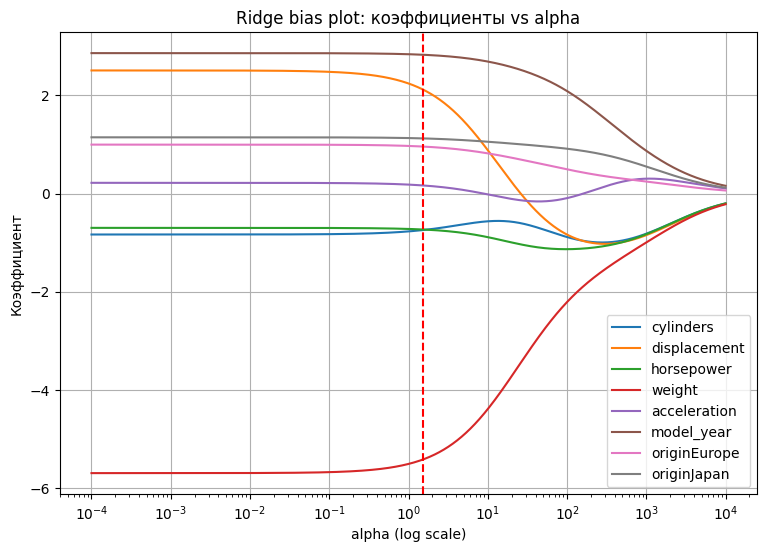

In [39]:
coefs = []
for a in alphaGrid:
    ridgeTmp = Ridge(alpha=a)
    ridgeTmp.fit(xMpgScaled, yMpg)
    coefs.append(ridgeTmp.coef_)

coefs = np.array(coefs)
plt.figure()
for i, col in enumerate(features):
    plt.semilogx(alphaGrid, coefs[:, i], label=col)
plt.axvline(bestAlpha, color='red', linestyle='--')
plt.xlabel('alpha (log scale)')
plt.ylabel('Коэффициент')
plt.title('Ridge bias plot: коэффициенты vs alpha')
plt.legend()
plt.grid(True)
plt.show()

### Итоговая Ridge-модель и сравнение с OLS

In [40]:
ridgeBest = Ridge(alpha=bestAlpha)
ridgeBest.fit(xMpgScaled, yMpg)
yPredRidge = ridgeBest.predict(xMpgScaled)

xMpgConst = sm.add_constant(xMpg)
olsModel = sm.OLS(yMpg, xMpgConst).fit()
yPredOls = olsModel.fittedvalues

print(f'Ridge (alpha={bestAlpha:.6g}):  MSE = {mean_squared_error(yMpg, yPredRidge):.4f},  R² = {r2_score(yMpg, yPredRidge):.4f}')
print(f'OLS:                    MSE = {mean_squared_error(yMpg, yPredOls):.4f},  R² = {olsModel.rsquared:.4f},  AIC = {olsModel.aic:.1f}')

print('\nOLS summary:')
print(olsModel.summary())

Ridge (alpha=1.54237):  MSE = 10.6922,  R² = 0.8240
OLS:                    MSE = 10.6821,  R² = 0.8242,  AIC = 2058.9

OLS summary:
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Thu, 11 Dec 2025   Prob (F-statistic):          1.79e-139
Time:                        23:05:29   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.9

### VIF для исходных предикторов

In [41]:
vifDf = pd.DataFrame()
vifDf['feature'] = features
vifDf['VIF'] = [variance_inflation_factor(xMpg.values, i) for i in range(xMpg.shape[1])]
print('VIF (Auto-MPG):')
display(vifDf.sort_values('VIF', ascending=False))

VIF (Auto-MPG):


,feature,VIF
3,weight,140.876665
0,cylinders,117.521073
5,model_year,111.917294
1,displacement,102.104942
4,acceleration,70.183974
2,horsepower,67.115852
7,originJapan,2.201570
6,originEurope,1.922502


## 2. Квантильная регрессия для mpg

In [42]:
taus = [0.1, 0.25, 0.5, 0.75, 0.9]
quantileResults = {}
xMpgConstQt = sm.add_constant(xMpg)

for tau in taus:
    qrModel = QuantReg(yMpg, xMpgConstQt).fit(q=tau)
    quantileResults[tau] = qrModel.params
    print(f'\nКвантиль tau = {tau}')
    print(qrModel.summary())

coefQuantileDf = pd.DataFrame(quantileResults).T
coefQuantileDf.index.name = 'tau'
display(coefQuantileDf.round(4))


Квантиль tau = 0.1
                         QuantReg Regression Results                          
Dep. Variable:                    mpg   Pseudo R-squared:               0.5222
Model:                       QuantReg   Bandwidth:                       1.635
Method:                 Least Squares   Sparsity:                        15.44
Date:                Thu, 11 Dec 2025   No. Observations:                  392
Time:                        23:05:29   Df Residuals:                      383
                                        Df Model:                            8
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.9968      6.895      0.435      0.664     -10.560      16.554
cylinders       -0.9359      0.490     -1.911      0.057      -1.899       0.027
displacement     0.0198      0.014      1.386      0.166      -0.008       0.048
horsepower      -0.044

,const,cylinders,displacement,horsepower,weight,acceleration,model_year,originEurope,originJapan
tau,,,,,,,,,
0.10,2.9968,-0.9359,0.0198,-0.0443,-0.0048,-0.2211,0.5194,1.3248,1.2298
0.25,-1.3887,-0.7803,0.0073,-0.0340,-0.0041,-0.2426,0.5876,0.5937,1.6246
0.50,-8.7908,-0.4430,0.0094,-0.0082,-0.0054,-0.0665,0.6530,1.9342,3.4607
0.75,-18.8925,-0.2594,0.0198,-0.0002,-0.0072,0.0216,0.8136,2.6475,3.0869
0.90,-26.1804,-0.6083,0.0261,-0.0030,-0.0077,0.0572,0.9611,3.3452,2.2546


### График коэффициентов vs tau

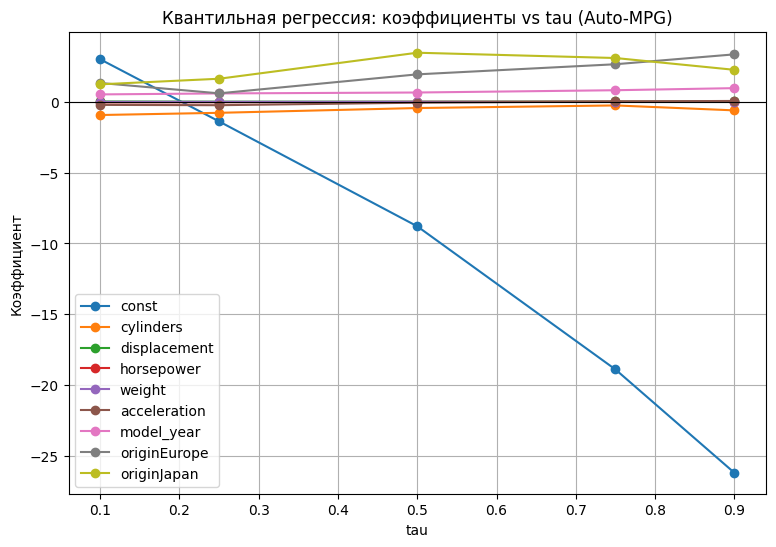

In [43]:
plt.figure()
for col in coefQuantileDf.columns:
    plt.plot(coefQuantileDf.index, coefQuantileDf[col], marker='o', label=col)
plt.axhline(0, color='k', linewidth=0.8)
plt.xlabel('tau')
plt.ylabel('Коэффициент')
plt.title('Квантильная регрессия: коэффициенты vs tau (Auto-MPG)')
plt.legend()
plt.grid(True)
plt.show()

### Сравнение OLS vs медианная регрессия


In [44]:
medianPred = xMpgConstQt @ quantileResults[0.5]

print('Сравнение на полной выборке:')
print(f'OLS:      MSE = {mean_squared_error(yMpg, yPredOls):.4f},  MAE = {mean_absolute_error(yMpg, yPredOls):.4f}')
print(f'Median:   MSE = {mean_squared_error(yMpg, medianPred):.4f},  MAE = {mean_absolute_error(yMpg, medianPred):.4f}')

Сравнение на полной выборке:
OLS:      MSE = 10.6821,  MAE = 2.5054
Median:   MSE = 11.4030,  MAE = 2.4347


## 3. Полиномиальная регрессия (квадратичная и кубическая)

In [ ]:
polyFeatures = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'originEurope', 'originJapan']
xPoly = autoMpgDataFrame[polyFeatures]

def fitPolyOls(Xdf, yvec, degree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xpoly = poly.fit_transform(Xdf)
    polyNames = poly.get_feature_names_out(Xdf.columns)
    XpolyDf = pd.DataFrame(Xpoly, columns=polyNames)
    XpolyConst = sm.add_constant(XpolyDf)
    model = sm.OLS(yvec, XpolyConst).fit()
    return model, XpolyConst

polyModels = {}
for deg in [2, 3]:
    model, _ = fitPolyOls(xPoly, yMpg, deg)
    polyModels[deg] = model
    print(f'\nПолиномиальная модель степени {deg}:')
    print(model.summary())


Полиномиальная модель степени 2:
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     78.33
Date:                Thu, 11 Dec 2025   Prob (F-statistic):          1.94e-151
Time:                        23:05:29   Log-Likelihood:                -906.47
No. Observations:                 392   AIC:                             1897.
Df Residuals:                     350   BIC:                             2064.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

### Сравнение моделей


In [46]:
comparisonData = [
    {'model': 'OLS_linear (все переменные)', 'aic': olsModel.aic, 'rmse': np.sqrt(mean_squared_error(yMpg, yPredOls)), 'r2': olsModel.rsquared},
    {'model': 'Poly degree 2', 'aic': polyModels[2].aic, 'rmse': np.sqrt(mean_squared_error(yMpg, polyModels[2].fittedvalues)), 'r2': polyModels[2].rsquared},
    {'model': 'Poly degree 3', 'aic': polyModels[3].aic, 'rmse': np.sqrt(mean_squared_error(yMpg, polyModels[3].fittedvalues)), 'r2': polyModels[3].rsquared}
]

comparisonDf = pd.DataFrame(comparisonData).set_index('model').round(4)
display(comparisonDf)

,aic,rmse,r2
model,,,
OLS_linear (все переменные),2058.9278,3.2684,0.8242
Poly degree 2,1896.9355,2.4436,0.9017
Poly degree 3,1831.7192,1.7782,0.9480


### Predicted vs Observed


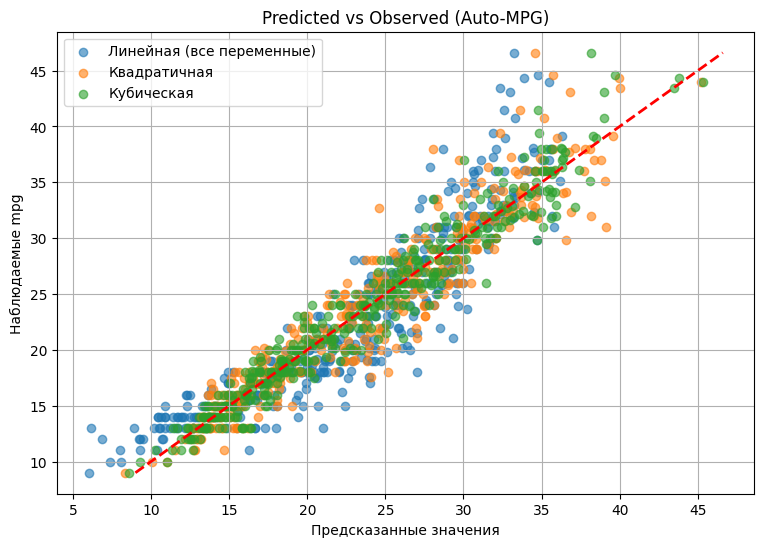

In [47]:
plt.figure()
plt.scatter(yPredOls, yMpg, label='Линейная (все переменные)', alpha=0.6)
plt.scatter(polyModels[2].fittedvalues, yMpg, label='Квадратичная', alpha=0.6)
plt.scatter(polyModels[3].fittedvalues, yMpg, label='Кубическая', alpha=0.6)
plt.plot([yMpg.min(), yMpg.max()], [yMpg.min(), yMpg.max()], 'r--', lw=2)
plt.xlabel('Предсказанные значения')
plt.ylabel('Наблюдаемые mpg')
plt.title('Predicted vs Observed (Auto-MPG)')
plt.legend()
plt.grid(True)
plt.show()